# Weight and node perturbation applied to MNIST

Exemplary code that demonstrates the learning of WP, NP and, for comparison, SGD for the MNIST task of the article

*Weight versus Node Perturbation Learning in Temporally Extended Tasks:
   Weight Perturbation Often Performs Similarly or Better*, PRX (2023)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# torch.set_default_dtype(torch.float64)  # Use double precision
# device = torch.device("cpu")  # Run on cpu
device = torch.device("cuda:0")  # Run on gpu


## Helper functions

In [2]:
### Data loading
def load_data(data_dir="./data", N_batch=100):
    """
    Load MNIST data set
    """

    # Data transformation
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    # Training and validation data set
    trainval_set = torchvision.datasets.MNIST(
        data_dir, download=True, transform=transform
    )
    train_set, val_set = torch.utils.data.random_split(trainval_set, [50_000, 10_000])
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=N_batch, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=N_batch, shuffle=True)

    # Test set
    test_set = torchvision.datasets.MNIST(
        data_dir,
        train=False,
        download=True,
        transform=transform,
    )
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=N_batch, shuffle=True
    )

    return train_loader, val_loader, test_loader


### Check accuracy and loss
def check_accuracy(net, criterion, data_loader):
    """
    Check accuracy and loss of neural network
    """

    check_loss = 0.0
    check_steps = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)
            inputs = inputs.flatten(start_dim=1)

            outputs = net(inputs)
            check_loss += criterion(outputs, labels).item()
            check_steps += 1
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return check_loss / check_steps, correct / total


## Weight update function

In [3]:
### Weight update
def dw_perturb(perturbs, loss, loss_pert, pstd, lr):
    """
    Compute weight update using perturbation method
    """
    
    grad = 1 / (pstd**2) * perturbs * (loss - loss_pert)
    dw = lr * grad
    return dw


## Neural Network

In [4]:
### Network object
class Net(nn.Module):
    """
    Neural network module
    """

    # Initialize network
    def __init__(self, N_h=100, N_layers=2):
        super(Net, self).__init__()
        if N_layers == 1:
            self.linears = nn.ModuleList([nn.Linear(784, 10)])
        else:
            self.linears = nn.ModuleList([nn.Linear(784, N_h)])
            self.linears.extend([nn.Linear(N_h, N_h) for _ in range(N_layers - 2)])
            self.linears.append(nn.Linear(N_h, 10))

    # Forward run
    def forward(self, x):
        for layer in self.linears[:-1]:
            x = torch.tanh(layer(x))
        output = self.linears[-1](x)
        return output

    # Perturbed forward run for NP
    def forward_np(self, x, perts):
        fc_acts = []
        for i, layer in enumerate(self.linears[:-1]):
            x = torch.tanh(layer(x) + perts[i])
            fc_acts.append(x)
        output = self.linears[-1](x) + perts[-1]
        return *fc_acts, output


## Training function

In [10]:
def train_mnist(config, data_dir="./data"):
    """
    Trains network on MNIST

    Parameters
    ----------
    config : dict
        Parameter configuration.
    data_dir : str, default="./data"
        Data directory for storage/loading of MNIST data set.
    """

    # Unpack parameters
    seed = config["seed"]
    rule = config["rule"]
    N_layers = int(config["N_layers"])
    N_batch = int(config["N_batch"])
    N_h = config["N_h"]
    N_epochs = config["N_epochs"]
    pstd = config["pstd"]
    lr = config["lr"]

    # Random seed
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Data loaders
    train_loader, val_loader, test_loader = load_data(data_dir, N_batch=N_batch)

    # Initializes network object
    net = Net(N_h, N_layers)
    net = net.to(device=device)
    if rule != "SGD":
        for params in net.parameters():
            params.requires_grad = False

    # Set criterion for learning
    criterion = torch.nn.CrossEntropyLoss()

    # Initialize optimizer
    if rule == "SGD":
        optimizer = torch.optim.SGD(net.parameters(), lr=lr)

    # Recording
    step = 0  # Number of update steps
    loss, acc = check_accuracy(net, criterion, test_loader)
    test_loss = [loss]
    test_acc = [acc]
    print("Epoch", "Step", "Loss", "Accuracy", sep="\t")
    print(50 * "-")
    print(0, step, f"{loss:.3f}", acc, sep="\t")

    # Learning loop
    for epoch in range(int(N_epochs * N_batch / 100)):

        for data in train_loader:
            step += 1  # Update number of update steps

            # Get the inputs
            inputs, labels = data
            inputs = inputs.to(device=device)
            inputs = inputs.flatten(start_dim=1)
            labels = labels.to(device=device)

            ### SGD
            if rule == "SGD":
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward + backward + update
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            ### WP
            elif rule == "WP":
                # Unperturbed run
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                # Perturbed run
                perturbs = []
                for params in net.parameters():
                    perturb = pstd * torch.randn(params.shape, device=device)
                    params.add_(perturb)
                    perturbs.append(perturb)
                outputs = net(inputs)
                loss_pert = criterion(outputs, labels)

                # Update
                for i, params in enumerate(net.parameters()):
                    dw = dw_perturb(
                        perturbs[i],
                        loss,
                        loss_pert,
                        pstd,
                        lr,
                    )
                    params.sub_(perturbs[i]).add_(dw)

            ### NP
            elif rule == "NP":
                # Unperturbed run
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                # Perturbed run
                perturbs = []
                for params in net.parameters():
                    if len(params.shape) == 1:
                        perturb = pstd * torch.randn(
                            (N_batch, params.shape[0]), device=device
                        )
                        perturbs.append(perturb)
                np_acts = list(net.forward_np(inputs, perturbs))
                loss_pert = criterion(np_acts[-1], labels)

                # Update
                fc_acts = [
                    inputs,
                    torch.ones((N_batch, 1), device=device),
                ]  # Ones to take biases into account
                for np_act in np_acts[:-1]:
                    fc_acts += [np_act, torch.ones((N_batch, 1), device=device)]
                perturbs = [perturbs[i // 2] for i in range(2 * len(perturbs))]
                for i, params in enumerate(net.parameters()):
                    dw = dw_perturb(
                        torch.squeeze((perturbs[i].T).mm(fc_acts[i])),
                        loss,
                        loss_pert,
                        pstd,
                        lr,
                    )
                    params.add_(dw)

        # Recording
        loss, acc = check_accuracy(net, criterion, test_loader)
        test_loss.append(loss)
        test_acc.append(acc)
        print(epoch + 1, step, f"{loss:.3f}", acc, sep="\t")

    return test_loss, test_acc


# Training the network

Training of one network instance using WP, NP and SGD. The learning rates `lr` are set to the values optimized for a batch size of `N_batch=100`.

### WP

In [6]:
config_WP = {
    "seed": 0,  # Random seed
    "rule": "WP",  # Update rule
    "N_layers": 2,  # Number of layers
    "N_batch": 100,  # Batch size
    "N_h": 100,  # Hidden layer sizes
    "N_epochs": 100,  # Number of epochs for N_batch=100 (fixed number of weight updates)
    "pstd": 1e-4,  # Perturbation STD
    "lr": 6.81e-4,  # Learning rate
}


In [7]:
loss_WP, acc_WP = train_mnist(config_WP, data_dir="./data")


Epoch	Step	Loss	Accuracy
--------------------------------------------------
0	0	2.301	0.0955
1	500	2.186	0.3582
2	1000	2.058	0.5551
3	1500	1.922	0.6681
4	2000	1.784	0.7002
5	2500	1.663	0.6942
6	3000	1.537	0.7233
7	3500	1.446	0.7406
8	4000	1.349	0.7549
9	4500	1.260	0.7652
10	5000	1.171	0.7696
11	5500	1.092	0.7775
12	6000	1.031	0.7852
13	6500	0.979	0.797
14	7000	0.932	0.8053
15	7500	0.894	0.814
16	8000	0.862	0.8213
17	8500	0.827	0.8243
18	9000	0.796	0.83
19	9500	0.767	0.8319
20	10000	0.744	0.8335
21	10500	0.725	0.8402
22	11000	0.699	0.8421
23	11500	0.678	0.8451
24	12000	0.663	0.8469
25	12500	0.652	0.8463
26	13000	0.639	0.8477
27	13500	0.626	0.8513
28	14000	0.615	0.853
29	14500	0.607	0.8537
30	15000	0.596	0.8554
31	15500	0.585	0.8598
32	16000	0.577	0.8597
33	16500	0.567	0.862
34	17000	0.560	0.8624
35	17500	0.550	0.8628
36	18000	0.542	0.8661
37	18500	0.534	0.8662
38	19000	0.528	0.8673
39	19500	0.523	0.8691
40	20000	0.518	0.8693
41	20500	0.511	0.8714
42	21000	0.505	0.8727
43	21500	0.498	0.8

### NP

In [8]:
config_NP = {
    "seed": 0,  # Random seed
    "rule": "NP",  # Update rule
    "N_layers": 2,  # Number of layers
    "N_batch": 100,  # Batch size
    "N_h": 100,  # Hidden layer sizes
    "N_epochs": 100,  # Number of epochs for N_batch=100 (fixed number of weight updates)
    "pstd": 1e-4,  # Perturbation STD
    "lr": 6.81e-4,  # Learning rate
}


In [11]:
loss_NP, acc_NP = train_mnist(config_NP, data_dir="./data")


Epoch	Step	Loss	Accuracy
--------------------------------------------------
0	0	2.301	0.0955
1	500	2.245	0.2025
2	1000	2.164	0.3641
3	1500	2.049	0.3407
4	2000	2.149	0.1238
5	2500	1.961	0.3684
6	3000	1.870	0.4435
7	3500	1.848	0.5277
8	4000	1.736	0.4984
9	4500	1.667	0.5491
10	5000	1.661	0.5328
11	5500	1.526	0.6469
12	6000	1.433	0.6304
13	6500	1.375	0.645
14	7000	1.300	0.7124
15	7500	1.298	0.6382
16	8000	1.218	0.6426
17	8500	1.153	0.7092
18	9000	1.137	0.7355
19	9500	1.040	0.7505
20	10000	1.032	0.763
21	10500	0.979	0.7477
22	11000	0.998	0.7188
23	11500	0.988	0.751
24	12000	0.939	0.7637
25	12500	0.915	0.7653
26	13000	0.903	0.7606
27	13500	0.918	0.7542
28	14000	0.864	0.7636
29	14500	0.874	0.7821
30	15000	0.816	0.8055
31	15500	0.816	0.8054
32	16000	0.810	0.7914
33	16500	0.807	0.785
34	17000	0.771	0.8155
35	17500	0.784	0.8202
36	18000	0.759	0.8289
37	18500	0.728	0.8388
38	19000	0.757	0.8031
39	19500	0.759	0.8174
40	20000	0.793	0.7826
41	20500	0.706	0.8225
42	21000	0.705	0.8358
43	21500	0.686	0

### SGD

In [12]:
config_SGD = {
    "seed": 0,  # Random seed
    "rule": "SGD",  # Update rule
    "N_layers": 2,  # Number of layers
    "N_batch": 100,  # Batch size
    "N_h": 100,  # Hidden layer sizes
    "N_epochs": 100,  # Number of epochs for N_batch=100 (fixed number of weight updates)
    "pstd": 0,  # Perturbation STD
    "lr": 0.562,  # Learning rate
}


In [13]:
loss_SGD, acc_SGD = train_mnist(config_SGD, data_dir="./data")


Epoch	Step	Loss	Accuracy
--------------------------------------------------
0	0	2.301	0.0955
1	500	0.190	0.9434
2	1000	0.141	0.9571
3	1500	0.110	0.9655
4	2000	0.097	0.9711
5	2500	0.093	0.9704
6	3000	0.079	0.9752
7	3500	0.077	0.9761
8	4000	0.077	0.9756
9	4500	0.080	0.9745
10	5000	0.076	0.9754
11	5500	0.074	0.9771
12	6000	0.074	0.9765
13	6500	0.077	0.9759
14	7000	0.072	0.9778
15	7500	0.072	0.9777
16	8000	0.072	0.9785
17	8500	0.075	0.9782
18	9000	0.075	0.9773
19	9500	0.071	0.9781
20	10000	0.074	0.9778
21	10500	0.074	0.9791
22	11000	0.074	0.9788
23	11500	0.074	0.9791
24	12000	0.075	0.9795
25	12500	0.076	0.9791
26	13000	0.075	0.9791
27	13500	0.075	0.9789
28	14000	0.076	0.9782
29	14500	0.077	0.9787
30	15000	0.077	0.9787
31	15500	0.077	0.9791
32	16000	0.077	0.9785
33	16500	0.078	0.9788
34	17000	0.078	0.9786
35	17500	0.079	0.9793
36	18000	0.079	0.9788
37	18500	0.079	0.979
38	19000	0.079	0.9792
39	19500	0.080	0.9787
40	20000	0.080	0.9794
41	20500	0.080	0.9792
42	21000	0.080	0.9794
43	21500	0.08

# Plotting the results

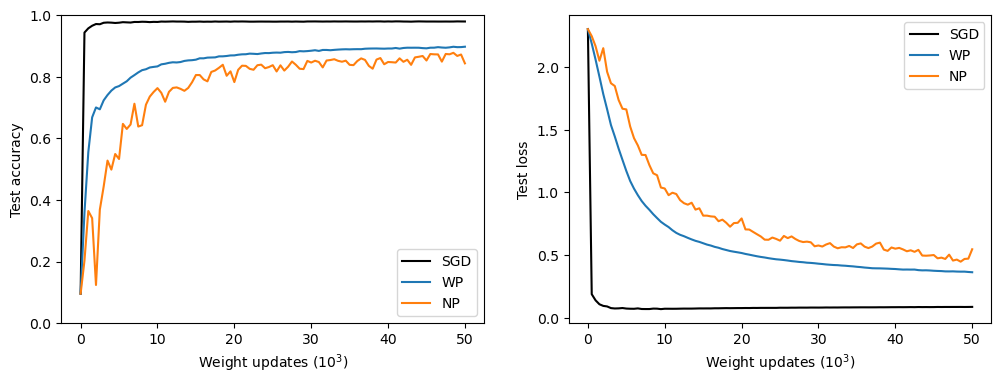

In [14]:
num_steps = int(
    50 * config_WP["N_epochs"] / 100
)  # Number of weight updates times 10^-3
steps = np.linspace(0, num_steps, len(loss_WP))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(steps, acc_SGD, label="SGD", color="k")
plt.plot(steps, acc_WP, label="WP")
plt.plot(steps, acc_NP, label="NP")
plt.legend()
plt.ylim(0, 1)
plt.xlabel("Weight updates ($10^3$)")
plt.ylabel("Test accuracy")

plt.subplot(1, 2, 2)
plt.plot(steps, loss_SGD, label="SGD", color="k")  # Slightly overfitted
plt.plot(steps, loss_WP, label="WP")
plt.plot(steps, loss_NP, label="NP")
plt.xlabel("Weight updates ($10^3$)")
plt.ylabel("Test loss")
plt.legend()

plt.show()
